In [2]:
%load_ext dotenv
%dotenv

In [3]:
# %load common.py
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', None)


PROJECT_PATH_ROOT = os.getenv('PROJECT_PATH_ROOT')
SEED = int(os.getenv('SEED'))

DATA_PATH = os.path.join(PROJECT_PATH_ROOT, "data", "raw")

TRAIN_PATH = os.path.join(DATA_PATH, "train.xlsx")
TEST_PATH = os.path.join(DATA_PATH, "test.xlsx")

In [4]:
train = pd.read_excel(TRAIN_PATH)
test = pd.read_excel(TEST_PATH)

In [5]:
train.sample(10, random_state=10)

,text,target
2072,Добрый вечер.у нас порвался оптический кабель...мастера заменить провод можно вызвать?,3
375,Добрый день не работает интернет,0
298,Здравствуйте. Почему такая маленькая скорость?,1
219,"Добрый день, как можно проверить скороть интернета?",1
1935,"Здравствуйте, скажите пожалуйста, почему интернет не работает? Только телевидение",0
168,"Здравствуйте,вчера оставляли заявку что бы нам поменяли провод",3
20,Здравствуйте. Перегнулся оптоволоконный кабель. Как вызвать специалиста на дом ? Платная ли эта услуга?,3
464,"Добрый день Пропало соединение, роутер перегрузил все тоже самое.",4
1046,"Здравствуйте, подскажите пожалуйста как сменить пароль на на вай-фай",2
176,"Здравствуйте. У меня подключена гарантия+ на оборудование. Могу ли я заменить неисправный роутер вайфай, который стал таковым после грозы? Гарантийный ли это случай?",8


In [6]:
from razdel import tokenize, sentenize

In [7]:
txt = "Здравствуйте. У меня подключена гарантия+ на оборудование. Могу ли я заменить неисправный роутер вайфай, который стал таковым после грозы? Гарантийный ли это случай?"

In [8]:
list(sentenize(txt))

[Substring(0, 13, 'Здравствуйте.'),
 Substring(14, 58, 'У меня подключена гарантия+ на оборудование.'),
 Substring(59,
           138,
           'Могу ли я заменить неисправный роутер вайфай, который стал таковым после грозы?'),
 Substring(139, 165, 'Гарантийный ли это случай?')]

In [9]:
train['cnt_sent'] = train.text.apply(lambda x: len(list(sentenize(x))))

In [10]:
def txt2list(txt):
    result = []
    for t in sentenize(txt):
        result.extend(tokenize(t.text))
    return [_.text for _ in result]

In [11]:
train['len_text'] = train.text.apply(lambda x: len(txt2list(x)))

In [12]:
train.cnt_sent.nunique()

10

<AxesSubplot:>

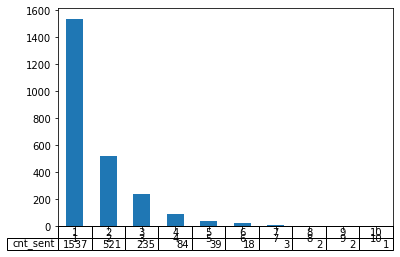

In [13]:
train.cnt_sent.value_counts().plot(kind='bar', rot=0, table=True)

C уверенностью можно сказать, что преобладают тексты, состоящие из малого числа предложений.
Скорее всего это короткие тексты

In [14]:
train.len_text.nunique()

76

<AxesSubplot:ylabel='Frequency'>

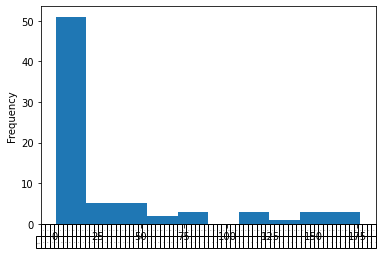

In [15]:
train.len_text.value_counts().plot(kind='hist', rot=0, table=True)

Подтверждаем, что преобладают короткие обращения, но 
все что больше 25 слов распределено "примерно" равномерно

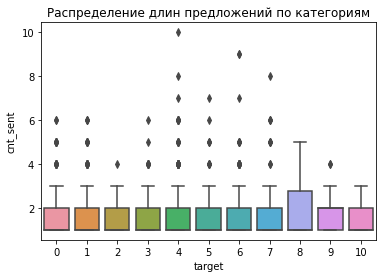

In [16]:
sns.boxplot(
    data=train,
    x="target",
    y="cnt_sent",
)
_ = plt.title("Распределение длин предложений по категориям")

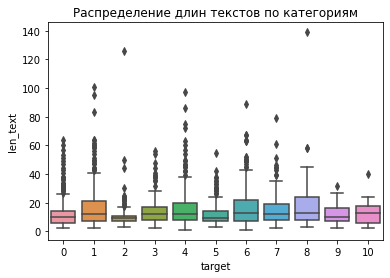

In [17]:
sns.boxplot(
    data=train,
    x="target",
    y="len_text",
)
_ = plt.title("Распределение длин текстов по категориям")

* Категории, связанные с интернетом имееют похожие боксы, кроме кат 0 (1, 4, 6)
* Категории 2 и 5, связанные с оборудованием с паролем имеют, в среднем, более короткие тексты
* У категорий 9 и 10 заметно отличается среднее
* У категорий есть различия по длине текста, может оказаться неплохим признаком

In [48]:
pd.crosstab(
    index=train.target, 
    columns=train["len_text"],
    margins=True
)

len_text,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,67,72,75,79,83,86,89,95,97,101,126,139,All
target,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,8,18,26,32,33,30,33,25,34,26,23,24,13,10,10,9,6,10,3,8,5,8,5,1,3,1,1,1,3,3,0,4,1,0,1,2,2,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,432
1,0,6,16,16,17,27,21,16,10,17,17,10,15,10,13,13,9,1,5,9,8,7,4,8,3,1,7,3,3,4,4,3,0,2,1,1,1,3,5,2,1,0,2,3,0,0,1,1,1,1,1,0,0,1,0,1,0,1,1,2,0,1,0,2,0,0,0,0,1,0,0,1,0,1,0,0,341
2,0,0,3,10,26,19,34,43,34,30,17,14,5,8,7,5,1,2,1,1,1,1,3,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,271
3,0,3,11,13,8,10,13,12,20,18,16,19,21,9,9,15,9,6,7,7,4,9,4,2,5,2,0,1,0,0,0,1,0,0,1,1,0,3,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,265
4,1,7,14,10,11,20,14,23,16,16,15,15,13,10,9,10,10,15,6,6,6,7,5,5,4,4,5,4,4,2,1,1,3,2,4,0,1,1,1,0,0,3,0,0,2,1,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,0,318
5,0,0,3,9,25,20,20,24,17,18,15,9,10,5,4,7,8,6,2,1,4,3,1,1,0,1,1,1,2,3,1,0,2,0,2,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229
6,1,6,8,16,12,13,5,10,8,11,11,11,10,9,8,7,4,8,9,4,4,5,7,6,2,1,4,1,1,1,2,2,2,0,0,0,1,1,3,0,1,1,1,0,2,0,1,0,4,3,0,2,0,0,0,0,0,0,0,0,0,0,2,1,2,0,0,0,0,0,1,0,0,0,0,0,235
7,0,2,4,10,8,15,11,8,13,13,14,12,11,9,4,9,5,5,5,2,5,6,4,6,2,3,0,3,3,4,1,2,0,0,2,0,0,0,2,0,0,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,210
8,0,0,3,5,6,1,2,3,3,7,3,5,2,4,1,3,1,0,4,1,0,1,2,2,2,0,2,1,3,0,1,0,2,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,78


* Наблюдаются некоторые особенности в виде:
    * Есть категории для которых характерных излишне короткие обращения
    * Есть категории для которых характерны излишне длинные обращения

<AxesSubplot:xlabel='target', ylabel='cnt_sent'>

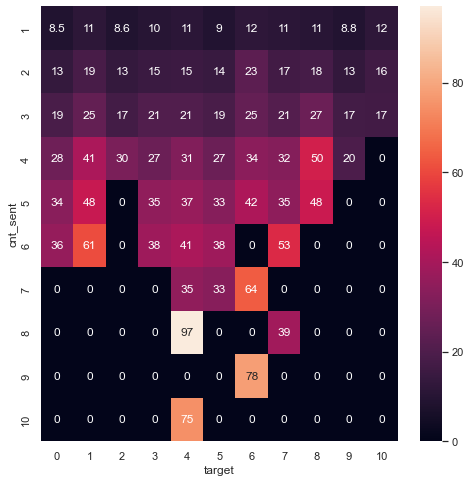

In [18]:
sns.set(rc={'figure.figsize': (8, 8)})
sns.heatmap(pd.pivot_table(
    train, 
    index="cnt_sent", 
    values='len_text', 
    columns='target', 
    aggfunc='mean', 
    fill_value=0
), annot=True)

Наблюдаем, что для некоторых категорий более характерны длинные предложения, чем для других

In [19]:
len(set(train.text.values))

2442

In [20]:
len(set(test.text.values))

250

In [21]:
from collections import Counter

In [34]:
def get_most_freq_word_by_cat(train, cat_id):
    tokens = []
    for text in tqdm(train[train.target == cat_id].text.values):
        for sent in sentenize(text):
            tokens.extend([_.text for _ in list(tokenize(sent.text))])
    counter = Counter(tokens)
    return counter

In [37]:
counters = [None for _ in range(11)]
for i in range(11):
    counters[i] = get_most_freq_word_by_cat(train, i)

100%|████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 3249.36it/s]


In [41]:
most_freq = 20
pd.DataFrame({
    "cat_0": counters[0].most_common(most_freq),
    "cat_1": counters[1].most_common(most_freq),
    "cat_2": counters[2].most_common(most_freq),
    "cat_3": counters[3].most_common(most_freq),
    "cat_4": counters[4].most_common(most_freq),
    "cat_5": counters[5].most_common(most_freq),
    "cat_6": counters[6].most_common(most_freq),
    "cat_7": counters[7].most_common(most_freq),
    "cat_8": counters[8].most_common(most_freq),
    "cat_9": counters[9].most_common(most_freq),
    "cat_10": counters[10].most_common(most_freq),
})

,cat_0,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,cat_9,cat_10
0,"(,, 318)","(,, 319)","(пароль, 268)","(,, 257)","(,, 299)","(пароль, 216)","(,, 252)","(,, 177)","(., 70)","(,, 23)","(,, 18)"
1,"(., 273)","(., 237)","(?, 138)","(., 169)","(., 279)","(от, 168)","(пинг, 180)","(., 125)","(,, 65)","(., 22)","(., 11)"
2,"(интернет, 216)","(скорость, 188)","(поменять, 135)","(кабель, 134)","(интернет, 124)","(,, 132)","(., 168)","(роутер, 93)","(роутер, 49)","(?, 19)","(?, 10)"
3,"(не, 198)","(интернета, 122)","(,, 122)","(Здравствуйте, 116)","(Здравствуйте, 90)","(., 114)","(в, 119)","(?, 83)","(?, 42)","(мастера, 18)","(в, 10)"
4,"(работает, 164)","(Здравствуйте, 119)","(на, 106)","(провод, 109)","(?, 90)","(?, 94)","(Здравствуйте, 79)","(пароль, 80)","(на, 39)","(вызвать, 16)","(Здравствуйте, 8)"
5,"(Здравствуйте, 153)","(не, 106)","(от, 105)","(?, 102)","(в, 88)","(Здравствуйте, 75)","(и, 75)","(и, 78)","(в, 25)","(на, 14)","(по, 6)"
6,"(?, 137)","(?, 104)","(Здравствуйте, 103)","(в, 63)","(с, 87)","(узнать, 68)","(?, 63)","(Здравствуйте, 76)","(и, 24)","(Здравствуйте, 12)","(я, 5)"
7,"(и, 94)","(с, 90)","(как, 97)","(вызвать, 60)","(не, 76)","(как, 59)","(меня, 61)","(настройки, 74)","(не, 23)","(!, 9)","(узнать, 5)"
8,"(Добрый, 85)","(в, 85)","(сменить, 73)","(мастера, 49)","(и, 75)","(вай, 50)","(у, 58)","(настроить, 64)","(день, 21)","(день, 9)","(к, 5)"
9,"(нет, 81)","(интернет, 74)","(Как, 72)","(на, 48)","(день, 63)","(не, 45)","(играх, 54)","(роутера, 57)","(Добрый, 20)","(Добрый, 8)","(Добрый, 4)"


* В каждой категории есть мусорные фразы вежливости, которые не несут смысловой нагрузки:
   * Добрый день
   * Здравствуйте
   * Пожалуйста
* По топ-20 слов визуально можно выделить интент и понять о его смысловой нагрузке
* Много склонений и ошибок - для непредобученных моделей может подойти стемминг или лемматизация, чтобы </br>
уменьшить число словоформ и из-за ошибок лучше использовать н-граммы

In [49]:
train['is_qmark'] = train.text.apply(lambda x: int("?" in x))
train['is_point'] = train.text.apply(lambda x: int("." in x))
train['is_comma'] = train.text.apply(lambda x: int("," in x))
train['is_exclamation'] = train.text.apply(lambda x: int("!" in x))

<AxesSubplot:ylabel='Frequency'>

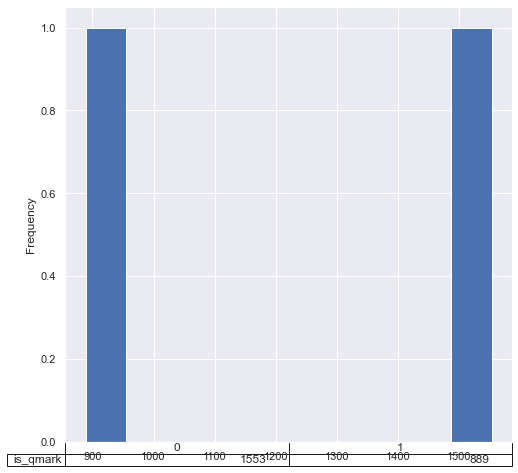

In [43]:
train.is_qmark.value_counts().plot(kind='hist', rot=0, table=True)

<AxesSubplot:ylabel='Frequency'>

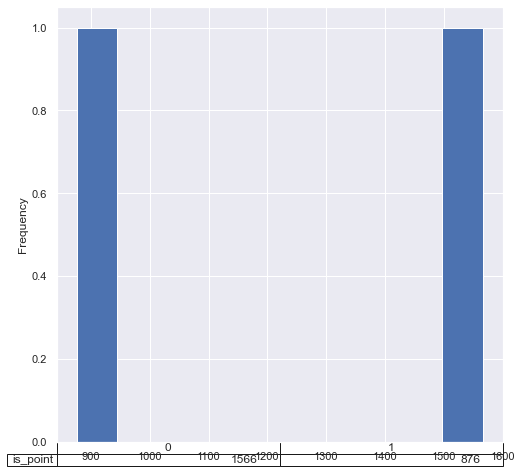

In [50]:
train.is_point.value_counts().plot(kind='hist', rot=0, table=True)

<AxesSubplot:ylabel='Frequency'>

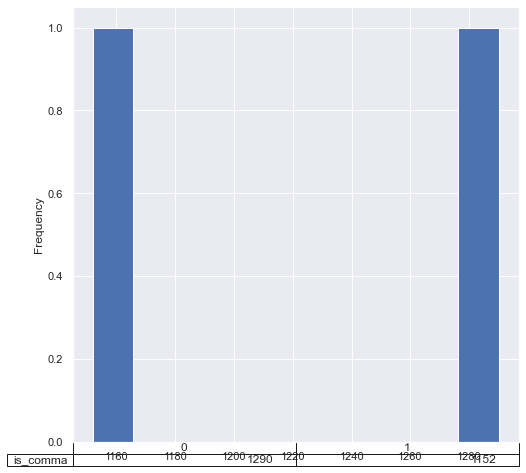

In [51]:
train.is_comma.value_counts().plot(kind='hist', rot=0, table=True)

<AxesSubplot:ylabel='Frequency'>

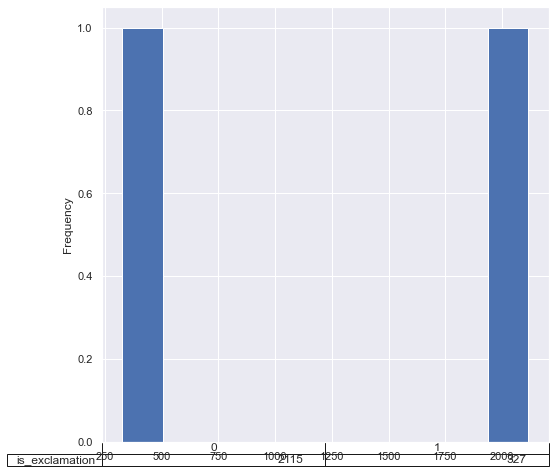

In [52]:
train.is_exclamation.value_counts().plot(kind='hist', rot=0, table=True)

In [56]:
train.is_exclamation.value_counts()

0    2115
1     327
Name: is_exclamation, dtype: int64

In [44]:
pd.crosstab(
    index=train.target, 
    columns=train["is_qmark"],
    margins=True
)

is_qmark,0,1,All
target,,,
0,292,140,432
1,232,109,341
2,132,139,271
3,160,105,265
4,224,94,318
5,136,93,229
6,170,65,235
7,136,74,210
8,37,41,78


* ? - характерны для первых 5 категорий
* меньше всего знаков ? в категориях 9 и 10

In [53]:
pd.crosstab(
    index=train.target, 
    columns=train["is_point"],
    margins=True
)

is_point,0,1,All
target,,,
0,270,162,432
1,208,133,341
2,220,51,271
3,158,107,265
4,184,134,318
5,158,71,229
6,155,80,235
7,133,77,210
8,43,35,78


* Не все категории любят точки? более характерны для категорий 0, 1, 3, 4

In [54]:
pd.crosstab(
    index=train.target, 
    columns=train.is_comma,
    margins=True
)

is_comma,0,1,All
target,,,
0,234,198,432
1,179,162,341
2,177,94,271
3,108,157,265
4,149,169,318
5,144,85,229
6,106,129,235
7,112,98,210
8,43,35,78


In [57]:
pd.crosstab(
    index=train.target, 
    columns=train.is_exclamation,
    margins=True
)

is_exclamation,0,1,All
target,,,
0,361,71,432
1,287,54,341
2,245,26,271
3,230,35,265
4,274,44,318
5,200,29,229
6,209,26,235
7,188,22,210
8,66,12,78


* Судя по данным, в категориях связанных с падением интернета больше всего возмущений (!)
* Меньше всего знаков (любых) в 9 и 10 категориях